## What you’ll learn and what you’ll build

In this section, we’ll take a look at how Transformers can be used to convert spoken speech into text, a task known speech recognition.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/asr_diagram.png)

Speech recognition, also known as automatic speech recognition (ASR) or speech-to-text (STT), is one of the most popular and exciting spoken language processing tasks. It’s used in a wide range of applications, including dictation, voice assistants, video captioning and meeting transcriptions.

You’ve probably made use of a speech recognition system many times before without realising! Consider the digital assistant in your smartphone device (Siri, Google Assistant, Alexa). When you use these assistants, the first thing that they do is transcribe your spoken speech to written text, ready to be used for any downstream tasks (such as finding you the weather 🌤️).

Speech recognition is a challenging task as it requires joint knowledge of audio and text. The input audio might have lots of background noise and be spoken by speakers with different accents, making it difficult to pick out the spoken speech. The written text might have characters which don’t have an acoustic sound, such as punctuation, which are difficult to infer from audio alone. These are all hurdles we have to tackle when building effective speech recognition systems!

Now that we’ve defined our task, we can begin looking into speech recognition in more detail. By the end of this Unit, you’ll have a good fundamental understanding of the different pre-trained speech recognition models available and how to use them with the 🤗 Transformers library. You’ll also know the procedure for fine-tuning an ASR model on a domain or language of choice, enabling you to build a performant system for whatever task you encounter. You’ll be able to showcase your model to your friends and family by building a live demo, one that takes any spoken speech and converts it to text!

## Pre-trained models for automatic speech recognition

In this section, we’ll cover how to use the pipeline() to leverage pre-trained models for speech recognition. In Unit 2, we introduced the pipeline() as an easy way of running speech recognition tasks, with all pre- and post-processing handled under-the-hood and the flexibility to quickly experiment with any pre-trained checkpoint on the Hugging Face Hub. In this Unit, we’ll go a level deeper and explore the different attributes of speech recognition models and how we can use them to tackle a range of different tasks.

As detailed in Unit 3, speech recognition model broadly fall into one of two categories:

1. **Connectionist Temporal Classification (CTC)**: encoder-only models with a linear classification (CTC) head on top
2. Sequence-to-sequence (Seq2Seq): encoder-decoder models, with a cross-attention mechanism between the encoder and decoder

**Prior to 2022, CTC was the more popular of the two architectures, with encoder-only models such as Wav2Vec2, HuBERT and XLSR achieving breakthoughs in the pre-training / fine-tuning paradigm for speech. Big corporations, such as Meta and Microsoft, pre-trained the encoder on vast amounts of unlabelled audio data for many days or weeks. Users could then take a pre-trained checkpoint, and fine-tune it with a CTC head on as little as 10 minutes of labelled speech data to achieve strong performance on a downstream speech recognition task.**

**However, CTC models have their shortcomings. Appending a simple linear layer to an encoder gives a small, fast overall model, but can be prone to phonetic spelling errors. We’ll demonstrate this for the Wav2Vec2 model below.**

### Probing CTC Models

Let’s load a small excerpt of the LibriSpeech ASR dataset to demonstrate Wav2Vec2’s speech transcription capabilities:

In [6]:
!pip install -q datasets[audio] transformers librosa

In [7]:
from datasets import load_dataset

dataset = load_dataset(
    "hf-internal-testing/librispeech_asr_dummy", "clean", split="validation"
)
dataset

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})

We can pick one of the 73 audio samples and inspect the audio sample as well as the transcription:



In [8]:
from IPython.display import Audio

sample = dataset[2]

print(sample["text"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND


Alright! Christmas and roast beef, sounds great! 🎄 Having chosen a data sample, we now load a fine-tuned checkpoint into the pipeline(). For this, we’ll use the official Wav2Vec2 base checkpoint fine-tuned on 100 hours of LibriSpeech data:



In [9]:
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-100h")

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

Next, we’ll take an example from the dataset and pass its raw data to the pipeline. Since the pipeline consumes any dictionary that we pass it (meaning it cannot be re-used), we’ll pass a copy of the data. This way, we can safely re-use the same audio sample in the following examples:



In [10]:
pipe(sample["audio"].copy())

{'text': 'HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAUS AND ROSE BEEF LOOMING BEFORE US SIMALYIS DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND'}

We can see that the Wav2Vec2 model does a pretty good job at transcribing this sample - at a first glance it looks generally correct. Let’s put the target and prediction side-by-side and highlight the differences:

```
Target:      HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
Prediction:  HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH **CHRISTMAUS** AND **ROSE** BEEF LOOMING BEFORE US **SIMALYIS** DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND<
```

Comparing the target text to the predicted transcription, we can see that all words sound correct, but some are not spelled accurately. For example:

- CHRISTMAUS vs. CHRISTMAS
- ROSE vs. ROAST
- SIMALYIS vs. SIMILES

**This highlights the shortcoming of a CTC model. A CTC model is essentially an ‘acoustic-only’ model: it consists of an encoder which forms hidden-state representations from the audio inputs, and a linear layer which maps the hidden-states to characters.**

This means that the system almost entirely bases its prediction on the acoustic input it was given (the phonetic sounds of the audio), and so has a tendency to transcribe the audio in a phonetic way (e.g. CHRISTMAUS). It gives less importance to the language modelling context of previous and successive letters, and so is prone to phonetic spelling errors. A more intelligent model would identify that CHRISTMAUS is not a valid word in the English vocabulary, and correct it to CHRISTMAS when making its predictions. We’re also missing two big features in our prediction - casing and punctuation - which limits the usefulness of the model’s transcriptions to real-world applications.



### Graduation to Seq2Seq

Cue Seq2Seq models! As outlined in Unit 3, Seq2Seq models are formed of an encoder and decoder linked via a cross-attention mechanism. The encoder plays the same role as before, computing hidden-state representations of the audio inputs, while the decoder plays the role of a language model. The decoder processes the entire sequence of hidden-state representations from the encoder and generates the corresponding text transcriptions. With global context of the audio input, the decoder is able to use language modelling context as it makes its predictions, correcting for spelling mistakes on-the-fly and thus circumventing the issue of phonetic predictions.

There are two downsides to Seq2Seq models:

1. They are inherently slower at decoding, since the decoding process happens one step at a time, rather than all at once
2. They are more data hungry, requiring significantly more training data to reach convergence

In particular, the need for large amounts of training data has been a bottleneck in the advancement of Seq2Seq architectures for speech. Labelled speech data is difficult to come by, with the largest annotated datasets at the time clocking in at just 10,000 hours. This all changed in 2022 upon the release of Whisper. Whisper is a pre-trained model for speech recognition published in September 2022 by the authors Alec Radford et al. from OpenAI. Unlike its CTC predecessors, which were pre-trained entirely on un-labelled audio data, Whisper is pre-trained on a vast quantity of labelled audio-transcription data, 680,000 hours to be precise.

This is an order of magnitude more data than the un-labelled audio data used to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this pre-training data is multilingual (or “non-English”) data. This results in checkpoints that can be applied to over 96 languages, many of which are considered low-resource, meaning the language lacks a large corpus of data suitable for training.

When scaled to 680,000 hours of labelled pre-training data, Whisper models demonstrate a strong ability to generalise to many datasets and domains. The pre-trained checkpoints achieve competitive results to state-of-the-art pipe systems, with near 3% word error rate (WER) on the test-clean subset of LibriSpeech pipe and a new state-of-the-art on TED-LIUM with 4.7% WER (c.f. Table 8 of the Whisper paper).

Of particular importance is Whisper’s ability to handle long-form audio samples, its robustness to input noise and ability to predict cased and punctuated transcriptions. This makes it a viable candidate for real-world speech recognition systems.

The remainder of this section will show you how to use the pre-trained Whisper models for speech recognition using 🤗 Transformers. In many situations, the pre-trained Whisper checkpoints are extremely performant and give great results, thus we encourage you to try using the pre-trained checkpoints as a first step to solving any speech recognition problem. Through fine-tuning, the pre-trained checkpoints can be adapted for specific datasets and languages to further improve upon these results. We’ll demonstrate how to do this in the upcoming subsection on fine-tuning.

The Whisper checkpoints come in five configurations of varying model sizes. The smallest four are trained on either English-only or multilingual data. The largest checkpoint is multilingual only. All nine of the pre-trained checkpoints are available on the Hugging Face Hub. The checkpoints are summarised in the following table with links to the models on the Hub. “VRAM” denotes the required GPU memory to run the model with the minimum batch size of 1. “Rel Speed” is the relative speed of a checkpoint compared to the largest model. Based on this information, you can select a checkpoint that is best suited to your hardware.

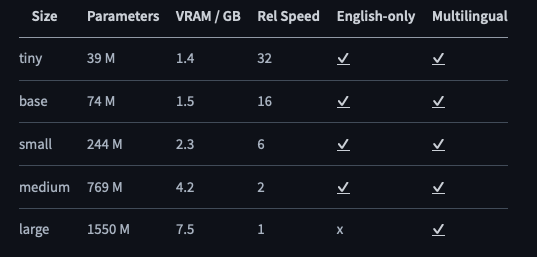

Let’s load the Whisper Base checkpoint, which is of comparable size to the Wav2Vec2 checkpoint we used previously. Preempting our move to multilingual speech recognition, we’ll load the multilingual variant of the base checkpoint. We’ll also load the model on the GPU if available, or CPU otherwise. The pipeline() will subsequently take care of moving all inputs / outputs from the CPU to the GPU as required:



In [11]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Great! Now let’s transcribe the audio as before. The only change we make is passing an extra argument, max_new_tokens, which tells the model the maximum number of tokens to generate when making its prediction:



In [12]:
pipe(sample["audio"], max_new_tokens=256)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `

{'text': ' He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similarly is drawn from eating and its results occur most readily to the mind.'}

Easy enough! The first thing you’ll notice is the presence of both casing and punctuation. Immediately this makes the transcription easier to read compared to the un-cased and un-punctuated transcription from Wav2Vec2. Let’s put the transcription side-by-side with the target:


```
Target:     HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
Prediction: He tells us that at this festive season of the year, with **Christmas** and **roast** beef looming before us, **similarly** is drawn from eating and its results occur most readily to the mind.
```

Whisper has done a great job at correcting the phonetic errors we saw from Wav2Vec2 - both Christmas and roast are spelled correctly. We see that the model still struggles with SIMILES, being incorrectly transcribed as similarly, but this time the prediction is a valid word from the English vocabulary. Using a larger Whisper checkpoint can help further reduce transcription errors, at the expense of requiring more compute and a longer transcription time.

We’ve been promised a model that can handle 96 languages, so lets leave English speech recognition for now and go global 🌎! The Multilingual LibriSpeech (MLS) dataset is the multilingual equivalent of the LibriSpeech dataset, with labelled audio data in six languages. We’ll load one sample from the Spanish split of the MLS dataset, making use of streaming mode so that we don’t have to download the entire dataset:


In [17]:
dataset = load_dataset(
    "facebook/multilingual_librispeech", "spanish", split="train", streaming=True
)
sample = next(iter(dataset))
sample

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

{'audio': {'path': '8882_10139_000000.opus',
  'array': array([-0.0008942 , -0.00100449, -0.00107663, ...,  0.00134036,
          0.00115272,  0.0010718 ]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/isladeltesoro_1509_librivox/isladeltesoro_14_stevenson_64kb.mp3',
 'begin_time': 578.82,
 'end_time': 589.02,
 'transcript': 'pestañeado quedóse en donde estaba apoyándose apenas en su muleta y con los ojos clavados en su compañero como una víbora lista para abalanzarse',
 'audio_duration': 10.199999999999932,
 'speaker_id': '8882',
 'chapter_id': '10139',
 'file': '8882_10139_000000.opus',
 'id': '8882_10139_000000'}

Again, we’ll inspect the text transcription and take a listen to the audio segment:



In [18]:
print(sample["transcript"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

pestañeado quedóse en donde estaba apoyándose apenas en su muleta y con los ojos clavados en su compañero como una víbora lista para abalanzarse


This is the target text that we’re aiming for with our Whisper transcription. Although we now know that we can probably do better this, since our model is also going to predict punctuation and casing, neither of which are present in the reference. Let’s forward the audio sample to the pipeline to get our text prediction. One thing to note is that the pipeline consumes the dictionary of audio inputs that we input, meaning the dictionary can’t be re-used. To circumvent this, we’ll pass a copy of the audio sample, so that we can re-use the same audio sample in the proceeding code examples:



In [19]:
pipe(sample["audio"].copy(), max_new_tokens=256, generate_kwargs={"task": "transcribe"})

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


{'text': ' Y dos en donde estaba, apoyándose apenas en su moleta, con los ojos clavados en su compañero, como una bíborra lista para balanzarse.'}

Great - this looks very similar to our reference text (arguably better since it has punctuation and casing!). You’ll notice that we forwarded the "task" as a generate key-word argument (generate kwarg). Setting the "task" to "transcribe" forces Whisper to perform the task of speech recognition, where the audio is transcribed in the same language that the speech was spoken in. Whisper is also capable of performing the closely related task of speech translation, where the audio in Spanish can be translated to text in English. To achieve this, we set the "task" to "translate":



In [20]:
pipe(sample["audio"], max_new_tokens=256, generate_kwargs={"task": "translate"})

You have passed task=translate, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=translate.


{'text': ' and two in which he was pulling just in his mouth, with his eyes clapped in his partner, with a live-or-alist to dance.'}

Now that we know we can toggle between speech recognition and speech translation, we can pick our task depending on our needs. Either we recognise from audio in language X to text in the same language X (e.g. Spanish audio to Spanish text), or we translate from audio in any language X to text in English (e.g. Spanish audio to English text).

To read more about how the "task" argument is used to control the properties of the generated text, refer to the model card for the Whisper base model.

### Long-Form Transcription and Timestamps

So far, we’ve focussed on transcribing short audio samples of less than 30 seconds. We mentioned that one of the appeals of Whisper was its ability to work on long audio samples. We’ll tackle this task here!

Let’s create a long audio file by concatenating sequential samples from the MLS dataset. Since the MLS dataset is curated by splitting long audiobook recordings into shorter segments, concatenating samples is one way of reconstructing longer audiobook passages. Consequently, the resulting audio should be coherent across the entire sample.

We’ll set our target audio length to 5 minutes, and stop concatenating samples once we hit this value:

In [21]:
import numpy as np

target_length_in_m = 5

# convert from minutes to seconds (* 60) to num samples (* sampling rate)
sampling_rate = pipe.feature_extractor.sampling_rate
target_length_in_samples = target_length_in_m * 60 * sampling_rate

# iterate over our streaming dataset, concatenating samples until we hit our target
long_audio = []
for sample in dataset:
    long_audio.extend(sample["audio"]["array"])
    if len(long_audio) > target_length_in_samples:
        break

long_audio = np.asarray(long_audio)

# how did we do?
seconds = len(long_audio) / 16000
minutes, seconds = divmod(seconds, 60)
print(f"Length of audio sample is {minutes} minutes {seconds:.2f} seconds")

Length of audio sample is 5.0 minutes 2.04 seconds


Alright! 5 minutes of audio to transcribe. There are two problems with forwarding this long audio sample directly to the model:

1. Whisper is inherently designed to work with 30 second samples: anything shorter than 30s is padded to 30s with silence, anything longer than 30s is truncated to 30s by cutting of the extra audio, so if we pass our audio directly we’ll only get the transcription for the first 30s
2. Memory in a transformer network scales with the sequence length squared: doubling the input length quadruples the memory requirement, so passing super long audio files is bound to lead to an out-of-memory (OOM) error

The way long-form transcription works in 🤗 Transformers is by chunking the input audio into smaller, more manageable segments. Each segment has a small amount of overlap with the previous one. This allows us to accurately stitch the segments back together at the boundaries, since we can find the overlap between segments and merge the transcriptions accordingly:

![](https://huggingface.co/blog/assets/49_asr_chunking/Striding.png)

The advantage of chunking the samples is that we don’t need the result of chunk
i
i to transcribe the subsequent chunk
i
+
1
i+1. The stitching is done after we have transcribed all the chunks at the chunk boundaries, so it doesn’t matter which order we transcribe chunks in. The algorithm is entirely stateless, so we can even do chunk
i
+
1
i+1 at the same time as chunk
i
i! This allows us to batch the chunks and run them through the model in parallel, providing a large computational speed-up compared to transcribing them sequentially. To read more about chunking in 🤗 Transformers, you can refer to this blog post.

To activate long-form transcriptions, we have to add one additional argument when we call the pipeline. This argument, chunk_length_s, controls the length of the chunked segments in seconds. For Whisper, 30 second chunks are optimal, since this matches the input length Whisper expects.

To activate batching, we need to pass the argument batch_size to the pipeline. Putting it all together, we can transcribe the long audio sample with chunking and batching as follows:

In [22]:
pipe(
    long_audio,
    max_new_tokens=256,
    generate_kwargs={"task": "transcribe"},
    chunk_length_s=30,
    batch_size=8,
)

{'text': ' Y dos en donde estaba apoyándose apenas en su moleta y con los ojos clavados en su compañero como una vibora lista para galanzarse. Ya tendremos noticias que enviar a nuestro buen digo es esto. Yo no soy ningún estudianteante y usted es un chico hilo muy leído yando fuerte con la peluca puesta sobre sus rodillas. Pero está yo tan compacto y tan cordial que confiso que me fue difícil convencerme de que aquellos mismos que lo daban estaban arreglando tramas infernales contra nuestras vidas. Tuvo la presencia de ánimo necesaria para dominarse y aparecer sereno. Si, señor, no más. Ven y dime si no es diablura y aquí mismo. A mis propios ojos les dejamos todos que tome la de Villadiego, rayos y truenos. Yo creo, muchachito. Sin embargo, el capitán Smolett no hizo el menor cambio a sus imposiciones anteriores. Si los sublevados logran salvarla empanizada y posicionarse de algunas de nuestras troneras no ocupadas, lo cierto es que de una cosa estábamos ya bien escasos y era de agua

We won’t print the entire output here since it’s pretty long (312 words total)! On a 16GB V100 GPU, you can expect the above line to take approximately 3.45 seconds to run, which is pretty good for a 317 second audio sample. On a CPU, expect closer to 30 seconds.

Whisper is also able to predict segment-level timestamps for the audio data. These timestamps indicate the start and end time for a short passage of audio, and are particularly useful for aligning a transcription with the input audio. Suppose we want to provide closed captions for a video - we need these timestamps to know which part of the transcription corresponds to a certain segment of video, in order to display the correct transcription for that time.

Activating timestamp prediction is straightforward, we just need to set the argument return_timestamps=True. Timestamps are compatible with both the chunking and batching methods we used previously, so we can simply append the timestamp argument to our previous call:

In [23]:
pipe(
    long_audio,
    max_new_tokens=256,
    generate_kwargs={"task": "transcribe"},
    chunk_length_s=30,
    batch_size=8,
    return_timestamps=True,
)["chunks"]

[{'timestamp': (0.0, 7.28),
  'text': ' Y dos en donde estaba apoyándose apenas en su moleta y con los ojos clavados en su compañero'},
 {'timestamp': (7.28, 10.4),
  'text': ' como una vibora lista para galanzarse.'},
 {'timestamp': (10.4, 15.8),
  'text': ' Ah, parecía un tiburón completo. De veras que sí.'},
 {'timestamp': (15.8, 27.0),
  'text': ' Así, si ahora cogemos a este Black Dog, ya tendremos noticias que enviar a nuestro buen patrón, el caballero Trilloni.'},
 {'timestamp': (27.0, 31.0),
  'text': ' 2. Te sitúas en el costado orientado allí.'},
 {'timestamp': (31.0, 34.0), 'text': ' 2. Yois, tú al otro lado, aloeste.'},
 {'timestamp': (34.0, 40.0),
  'text': ' 2. Señor de Trilloni, a usted que es el de mejor puntería, se le encomienda.'},
 {'timestamp': (40.0, 44.0),
  'text': ' 2. Ayudado por Grey, todo estaba un en la misma posición.'},
 {'timestamp': (44.0, 46.12), 'text': ' 2. El hombre del gorro encarnado'},
 {'timestamp': (46.12, 51.9),
  'text': ' todavía habitada de

Eh voila! We have our predicted text as well as corresponding timestamps.

### Summary

Whisper is a strong pre-trained model for speech recognition and translation. Compared to Wav2Vec2, it has higher transcription accuracy, with outputs that contain punctuation and casing. It can be used to transcribe speech in English as well as 96 other languages, both on short audio segments and longer ones through chunking. These attributes make it a viable model for many speech recognition and translation tasks without the need for fine-tuning. The pipeline() method provides an easy way of running inference in one-line API calls with control over the generated predictions.

While the Whisper model performs extremely well on many high-resource languages, it has lower transcription and translation accuracy on low-resource languages, i.e. those with less readily available training data. There is also varying performance across different accents and dialects of certain languages, including lower accuracy for speakers of different genders, races, ages or other demographic criteria (c.f. Whisper paper).

To boost the performance on low-resource languages, accents or dialects, we can take the pre-trained Whisper model and train it on a small corpus of appropriately selected data, in a process called fine-tuning. We’ll show that with as little as ten hours of additional data, we can improve the performance of the Whisper model by over 100% on a low-resource language. In the next section, we’ll cover the process behind selecting a dataset for fine-tuning.